In [609]:
from pathlib import Path
import warnings
import os
import torch.nn as nn
from captum.attr import IntegratedGradients, LRP
import torch as ch
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib as mpl
from sklearn.manifold import TSNE
mpl.rcParams['figure.dpi'] = 150

from distribution_inference.datasets.utils import get_dataset_wrapper, get_dataset_information
from distribution_inference.attacks.utils import get_dfs_for_victim_and_adv
from distribution_inference.attacks.whitebox.utils import get_attack, wrap_into_loader
from distribution_inference.attacks.whitebox.affinity.utils import get_loader_for_seed_data
from distribution_inference.config import DatasetConfig, AttackConfig, WhiteBoxAttackConfig, TrainConfig
from distribution_inference.utils import flash_utils, warning_string
from distribution_inference.logging.core import AttackResult
from distribution_inference.attacks.blackbox.core import sigmoid
import os
gpu = "0,1,2,3"
os.environ["CUDA_VISIBLE_DEVICES"] = gpu

In [664]:
class Wrapper(nn.Module):
    def __init__(self,amc):
        super().__init__()
        self.amc = amc

    def forward(self, *args):
        # Wrap args into one list
        return self.amc(args)

In [665]:
def collate_fn(data):
    features, labels = zip(*data)
    # Combine them per-layer
    x = [[] for _ in range(len(features[0]))]
    for feature in features:
        for i, layer_feature in enumerate(feature):
            x[i].append(layer_feature)

    x = [ch.stack(x_, 0) for x_ in x]
    y = ch.tensor(labels).float()

    return x, y

class BasicDataset(ch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        assert len(self.X) == len(self.Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Create laoaders out of all the given data
def get_loader(data, shuffle):
    ds = BasicDataset(data[0], data[1])
    return ch.utils.data.DataLoader(
        ds, batch_size=wb_attack_config.batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle)

In [676]:
def reverse_ind(x, leng):
#get the indexes of points from the index of pairs, x. leng is # of points
    indices_i, indices_j = [], []
    f = np.arange(leng)
    for j in f[:-1]:
        others = f[j+1:]
        indices_i += [j] * len(others)
        indices_j += list(range(j+1, leng))
    indices_i = np.array(indices_i)
    indices_j = np.array(indices_j)
    return (indices_i[x], indices_j[x])

In [2]:
load_config = Path("./cel_AMC_interp.json")
meta_path = "/p/adversarialml/as9rw/tmp/celeba/Male"

In [3]:
attack_config: AttackConfig = AttackConfig.load(
        load_config, drop_extra_fields=False)
wb_attack_config: WhiteBoxAttackConfig = attack_config.white_box
train_config: TrainConfig = attack_config.train_config
data_config: DatasetConfig = train_config.data_config
if train_config.misc_config is not None:
        # TODO: Figure out best place to have this logic in the module
    if train_config.misc_config.adv_config:
            # Scale epsilon by 255 if requested
        if train_config.misc_config.adv_config.scale_by_255:
            train_config.misc_config.adv_config.epsilon /= 255
if len(attack_config.values) != 1:
        warnings.warn(warning_string(
            "\nTesting one meta-classifier against multiple ratios.\n"))
values_to_test = [str(x) for x in attack_config.values]
folders = os.listdir(meta_path)
for value in values_to_test:
    if value not in folders:
        raise ValueError(
            f"No model found for value {value} in {meta_path}")

ds_wrapper_class = get_dataset_wrapper(data_config.name)

# Get dataset info object
ds_info = get_dataset_information(data_config.name)()

# Create new DS object for both and victim
_, data_config_vic_1 = get_dfs_for_victim_and_adv(
        data_config)
ds_vic_1 = ds_wrapper_class(data_config_vic_1, skip_data=True)

In [705]:
#n_vic_models = attack_config.num_victim_models
n_vic_models = 100

models_vic_1 = ds_vic_1.get_models(
            train_config,
            n_models=n_vic_models,
            on_cpu=attack_config.on_cpu,
            shuffle=True,
            model_arch=attack_config.victim_model_arch,
            custom_models_path=None,)

# For each value (of property) asked to experiment with
for i, prop_value in enumerate([attack_config.values[1]]):
    # Creata a copy of the data config, with the property value
    # changed to the current value
    _, data_config_vic_2 = get_dfs_for_victim_and_adv(
                data_config, prop_value=prop_value)

    # Create new DS object for both and victim (for other ratio)
    ds_vic_2 = ds_wrapper_class(data_config_vic_2, skip_data=True)

    # Load victim's model for other value
    models_vic_2 = ds_vic_2.get_models(
                train_config,
                n_models=n_vic_models,
                on_cpu=attack_config.on_cpu,
                shuffle=True,
                model_arch=attack_config.victim_model_arch,
                custom_models_path=None)

    # Generate test set
    test_data = wrap_into_loader(
                [models_vic_1, models_vic_2],
                batch_size=wb_attack_config.batch_size,
                shuffle=True,
                wrap_with_loader=False)

    # Look at all models
    attack_model_path_dir = os.path.join(
                meta_path, str(prop_value))
    for attack_model_path in [os.listdir(attack_model_path_dir)[0]]:
        # Skip if directory
        if os.path.isdir(os.path.join(attack_model_path_dir, attack_model_path)):
                    continue

        # Create attacker object
        attacker_obj = get_attack(wb_attack_config.attack)(
                    None, wb_attack_config)

        # Load model
        attacker_obj.load_model(os.path.join(
                    attack_model_path_dir, attack_model_path))
        
        # Make seed-data loader for this attack
        seed_data_loader = get_loader_for_seed_data(
                    attacker_obj.seed_data_ds, wb_attack_config)
        # Create affinity features
        features_test = attacker_obj.make_affinity_features(
                    test_data[0], seed_data_loader)

Loading models:   1%|█▊                                                                                                                                                                                      | 1/100 [00:00<00:16,  5.99it/s]

Available models: 100


Loading models:   0%|                                                                                                                                                                                                | 0/100 [00:00<?, ?it/s]

Available models: 100


Building affinity matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:57<00:00,  1.70it/s]


In [706]:
print("Loaded ratio", prop_value)

Loaded ratio 0.1


In [707]:
w = Wrapper(attacker_obj.model)

In [708]:
test_loader_ = get_loader((features_test, test_data[1]), True)
data, labels = next(iter(test_loader_))
data = [x.cuda().requires_grad_() for x in data]

In [709]:
# Wonder if we should only focus on examples where the meta-classifier is correct
preds = 1 * (attacker_obj.model(data)[:, 0] >= 0).cpu()
correct = (preds == labels)
print("Accuracy: %.3f" % ch.mean(1. * correct))

picked_data = [d[correct] for d in data]

Accuracy: 0.915


In [710]:
ig = LRP(w)
# ig = IntegratedGradients(w)
test_input_tensor = data

#test_input_tensor.requires_grad_()
attr, delta = ig.attribute((*test_input_tensor,),
                           target=0,
                           return_convergence_delta=True,)

In [711]:
attr = [x.cpu().detach().numpy() for x in attr]
# First N-1 correspond to pair-wise correlations
# Last corresponds to direct prediction scores
attr_single = attr[-1]

In [712]:
# Look at "layer-wise" scores to see which layer's activations contributes the most
layerwise_attrs = np.array([np.abs(x).mean() for x in attr])
# Print out order of importance for layers
important_layers = np.argsort(np.abs(layerwise_attrs))[::-1]
for il in important_layers:
    print("Layer %d : %.4f" % (il, layerwise_attrs[il]))

Layer 0 : 0.1676
Layer 1 : 0.0853
Layer 3 : 0.0774
Layer 2 : 0.0718
Layer 4 : 0.0000


In [713]:
"""
# Need extra work. Wrapper and AMC have no layer
# Try layer attribution to see which layers seem to be most helpful
ig = LayerIntegratedGradients(w)
test_input_tensor = data
#test_input_tensor.requires_grad_()
attr_layer, delta_layer = ig.attribute((*test_input_tensor,),
                           target=0,
                           return_convergence_delta=True)
#attr = attr.cpu().detach().numpy()
print(attr_layer)
"""

'\n# Need extra work. Wrapper and AMC have no layer\n# Try layer attribution to see which layers seem to be most helpful\nig = LayerIntegratedGradients(w)\ntest_input_tensor = data\n#test_input_tensor.requires_grad_()\nattr_layer, delta_layer = ig.attribute((*test_input_tensor,),\n                           target=0,\n                           return_convergence_delta=True)\n#attr = attr.cpu().detach().numpy()\nprint(attr_layer)\n'

In [714]:
# Looks at everything except last layer
attr = attr[:4]
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#plt.figure(dpi=1200)
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    #print(title)
    # for i in range(len(feature_names)):
        # print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)

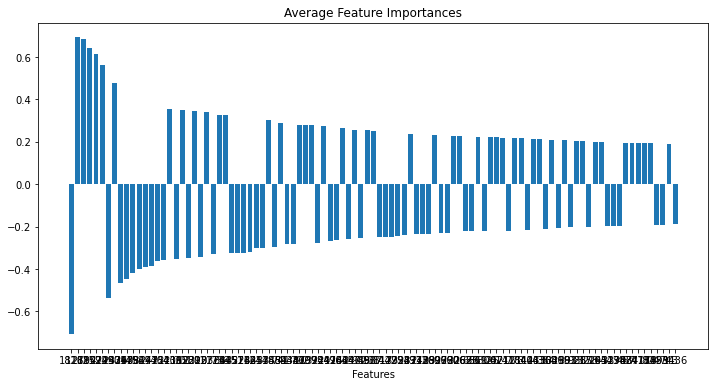

In [715]:
# Overall-based
# means = np.mean(np.mean(attr,axis=0), axis=0)
# means = np.median(np.median(attr,axis=0), axis=0)

# Focus-layer based
focus_layer = important_layers[0]
means = np.mean(attr[focus_layer], axis=0)

n_look_at = int(0.1 * len(means))

ind = np.argsort(np.absolute(means))[::-1][:n_look_at] # Top X%
# ind = np.argsort(np.absolute(means))[::-1][-n_look_at:] # Bottom X%

# Check if the "common point" trend also holds for random features
# ind = np.random.permutation(means.shape[0])[:n_look_at]

visualize_importances(attacker_obj.retained_pairs[ind], means[ind])

In [716]:
# Obtain (i, j) form of pairs by reversing indices corresponding to flattened pairs
p_ind = reverse_ind(attacker_obj.retained_pairs[ind],len(attacker_obj.seed_data_ds))

# Extract corresponding data (raw images)
pis = attacker_obj.seed_data_ds[p_ind[0]].cuda()
pjs = attacker_obj.seed_data_ds[p_ind[1]].cuda()

# And corresponding model predictions (on task) for these points
pred_i_og = (sigmoid(np.array([m.cuda().eval()(pis).cpu().detach().numpy() for m in models_vic_1])),sigmoid(np.array([m.cuda().eval()(pis).cpu().detach().numpy() for m in models_vic_2])))
pred_j_og = (sigmoid(np.array([m.cuda().eval()(pjs).cpu().detach().numpy() for m in models_vic_1])),sigmoid(np.array([m.cuda().eval()(pjs).cpu().detach().numpy() for m in models_vic_2])))

# Take note of average prediction per point across models
pred_i = [np.mean(x,axis=0) for x in pred_i_og]
pred_j = [np.mean(x,axis=0) for x in pred_j_og]

In [717]:
# Take note of most frequent images for each of (i, j)
first, first_c = np.unique(p_ind[0], return_counts=True)
most_common_first = first[np.argmax(first_c)]
second, second_c = np.unique(p_ind[1], return_counts=True)
most_common_second = second[np.argmax(second_c)]
print(most_common_first, most_common_second)

15 71


In [718]:
# Extract features for most important layers
# And plot them in 2D, see if they form clusters across models

focus_layer = 2
pis_relevant_1 = np.array([m.cuda().eval()(pis, get_all=True, detach_before_return=True)[focus_layer].cpu().numpy() for m in models_vic_1])
pis_relevant_2 = np.array([m.cuda().eval()(pis, get_all=True, detach_before_return=True)[focus_layer].cpu().numpy() for m in models_vic_2])
pjs_relevant_1 = np.array([m.cuda().eval()(pjs, get_all=True, detach_before_return=True)[focus_layer].cpu().numpy() for m in models_vic_1])
pjs_relevant_2 = np.array([m.cuda().eval()(pjs, get_all=True, detach_before_return=True)[focus_layer].cpu().numpy() for m in models_vic_2])
# Shape: (models, pairs, per-pair features)
num_feats = pis_relevant_1.shape[-1]

# Look at each model's behavior w.r.t data from D0 or D1
num_acts_i_1 = np.mean(np.mean(pis_relevant_1, 2), 1)
num_acts_i_2 = np.mean(np.mean(pis_relevant_2, 2), 1)
num_acts_j_1 = np.mean(np.mean(pjs_relevant_1, 2), 1)
num_acts_j_2 = np.mean(np.mean(pjs_relevant_2, 2), 1)
diff_1 = (num_acts_i_1 - num_acts_j_1)
diff_2 = (num_acts_i_2 - num_acts_j_2)
print("M0: %.3f +/- %.3f" % (np.mean(diff_1), np.std(diff_1)))
print("M1: %.3f +/- %.3f" % (np.mean(diff_2), np.std(diff_2)))

pis_relevant_1 = pis_relevant_1.reshape(-1, pis_relevant_1.shape[-1])
pis_relevant_2 = pis_relevant_2.reshape(-1, pis_relevant_2.shape[-1])
pjs_relevant_1 = pjs_relevant_1.reshape(-1, pjs_relevant_1.shape[-1])
pjs_relevant_2 = pjs_relevant_2.reshape(-1, pjs_relevant_2.shape[-1])

M0: -0.243 +/- 0.188
M1: -0.225 +/- 0.123


In [719]:
pis_fireup_1 = np.sum(pis_relevant_1 > 0, 1)
pis_fireup_2 = np.sum(pis_relevant_2 > 0, 1)
pjs_fireup_1 = np.sum(pjs_relevant_1 > 0, 1)
pjs_fireup_2 = np.sum(pjs_relevant_2 > 0, 1)

print("M0: %.3f (D0) v/s %.3f (D1)" % (np.mean(pis_fireup_1)/num_feats, np.mean(pjs_fireup_1)/num_feats))
print("M1: %.3f (D0) v/s %.3f (D1)" % (np.mean(pis_fireup_2)/num_feats, np.mean(pjs_fireup_2)/num_feats))

M0: 0.528 (D0) v/s 0.498 (D1)
M1: 0.508 (D0) v/s 0.477 (D1)


In [720]:
# 0.0: (M1>M0, M1~M0 (> if look at 0), M1>M0) , Layer (0, 2/3/0, 0) most useful
# 0.1: (M1>M0 [specific], M1>M0, M1>M0), Layer (0/3, 0, 1/3) most useful
# 0.2: (M1>M0, M1~M0, M1~M0), Layer (3/0, 3/0, 0/3) most useful
# 0.3: (M1>M0, M1>M0, M1>M0), Layer (0/2, 0, 0) most useful
# 0.4:
# 0.7: (M1>M0, M0>M1, M0>M1), Layer (3/1/0, 0, 0) most useful
# 0.8: (?, M1>M0, M1>M0), Layer (4, 2/0, 2) most useful
# 0.9: (M0>M1, M1~M0, M0>M1), Layer (0, 2/0, 0) most useful
# 1.0: (M0>M1, M0>M1, M1>M0), Layer (0, 0, 3/0) most useful

In [721]:
# focus_layer = 0
pairids = attacker_obj.retained_pairs[ind]
num_each_models = len(data[focus_layer]) // 2
m0_cosines = data[focus_layer][:num_each_models].detach().cpu().numpy()
m1_cosines = data[focus_layer][num_each_models:].detach().cpu().numpy()

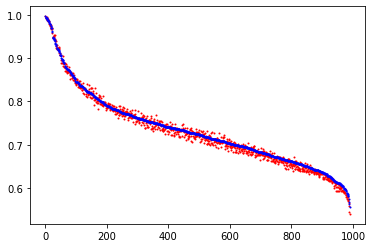

In [722]:
# Simple plot of cosine scores for both models (means)
# Get sorting order according to one of them
sorting_order = np.argsort(np.mean(m1_cosines, 0))[::-1]

means_1 = np.mean(m0_cosines, 0)[sorting_order]
means_2 = np.mean(m1_cosines, 0)[sorting_order]
plt.scatter(np.arange(m0_cosines.shape[1]), means_1, c='r', s=1)
plt.scatter(np.arange(m1_cosines.shape[1]), means_2, c='b', s=1)

Cell above looks at the top X% useful features and their corresponding cosine scores (mean) across models, for different types (colors) of models. Plotting them shows some subtle trends (differences) in some cases, and none in most.

In [723]:
# Out of curiosity, see what the distinguishing accuracy would be based on a simple threshold between these means.
means_mid = (means_1 + means_2) / 2

preds_0 = np.mean(m0_cosines[:, sorting_order].T >= np.expand_dims(means_mid, 1), 0)
preds_1 = np.mean(m1_cosines[:, sorting_order].T >= np.expand_dims(means_mid, 1), 0)
acc = np.sum(preds_0 >= 0.5) + np.sum(preds_1 < 0.5)
acc /= (m0_cosines.shape[0] + m1_cosines.shape[0])
print("Maximum distuishing accuracy based on just these values: %.3f" %  max(acc, 1 - acc))

Maximum distuishing accuracy based on just these values: 0.535


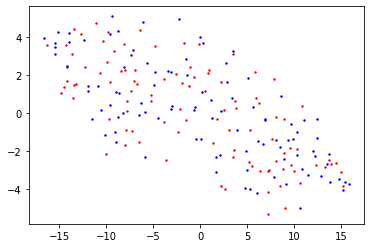

In [724]:
# Get t-SNE embeddings (will take a while)
X_all = np.concatenate((m0_cosines, m1_cosines), 0)
X_embed = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_all)

# Plot in graph
so_far = 0
plt.scatter(X_embed[so_far:so_far+num_each_models, 0], X_embed[so_far:so_far+num_each_models, 1], c='r', marker='o', s=2)
so_far += num_each_models
plt.scatter(X_embed[so_far:so_far+num_each_models, 0], X_embed[so_far:so_far+num_each_models, 1], c='b', marker='o', s=2)

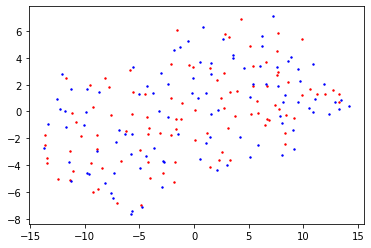

In [725]:
# Get t-SNE embeddings (will take a while), but only for "useful" features
X_embed = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_all[:, ind])

# Plot in graph
so_far = 0
plt.scatter(X_embed[so_far:so_far+num_each_models, 0], X_embed[so_far:so_far+num_each_models, 1], c='r', marker='o', s=2)
so_far += num_each_models
plt.scatter(X_embed[so_far:so_far+num_each_models, 0], X_embed[so_far:so_far+num_each_models, 1], c='b', marker='o', s=2)

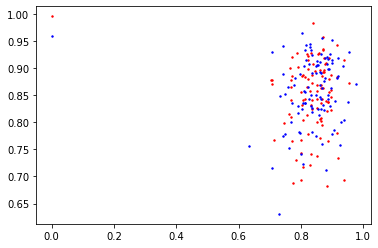

In [726]:
# Even simpler- a scatter with the top-2 similarity scores

X_embed = X_all[:, ind[:2]]
so_far = 0
plt.scatter(X_embed[so_far:so_far+num_each_models, 0], X_embed[so_far:so_far+num_each_models, 1], c='r', marker='o', s=2)
so_far += num_each_models
plt.scatter(X_embed[so_far:so_far+num_each_models, 0], X_embed[so_far:so_far+num_each_models, 1], c='b', marker='o', s=2)

As apparent, there is quite some variation in the similarity scores across models, with high correlation between both sets of models.

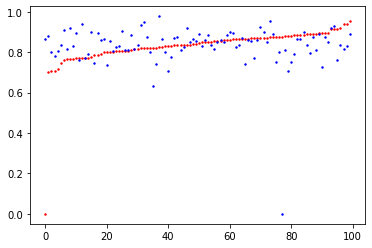

In [727]:
# Look at the most "useful" feature and its values for first set of models, and then for second set of models
X_embed = X_all[:, ind[0]]

so_far = 0
sorted_order = np.argsort(X_embed[so_far:so_far+num_each_models])
plt.scatter(np.arange(num_each_models), X_embed[so_far:so_far+num_each_models][sorted_order], c='r', marker='o', s=2)
so_far += num_each_models
plt.scatter(np.arange(num_each_models), X_embed[so_far:so_far+num_each_models][sorted_order], c='b', marker='o', s=2)


Another angle to look at the data- trends across models to see if any one is consistently lower/higher than the orher. As visible, there are no clear trends.

In [728]:
# Get t-SNE embeddings (will take a while)
# X_all = np.concatenate((pis_relevant_1, pis_relevant_2, pjs_relevant_1, pjs_relevant_2), 0)
# X_embed = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_all)

In [729]:
# Get t-SNE embeddings (will take a while)
# X_all = np.concatenate((pis_relevant_1, pis_relevant_2), 0)
# X_embed = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_all)

In [730]:
# # Plot in graph
# so_far = 0
# plt.scatter(X_embed[so_far:so_far+len(pis_relevant_1), 0], X_embed[:len(pis_relevant_1), 1], c='r', marker='o', s=2)
# so_far += len(pis_relevant_1)
# plt.scatter(X_embed[so_far:so_far+len(pis_relevant_2), 0], X_embed[:len(pis_relevant_1), 1], c='b', marker='o', s=2)
# so_far += len(pis_relevant_2)
# # plt.scatter(X_embed[so_far:so_far+len(pjs_relevant_1), 0], X_embed[:len(pis_relevant_1), 1], c='r', marker='+', s=2)
# # so_far += len(pjs_relevant_1)
# # plt.scatter(X_embed[so_far:, 0], X_embed[:len(pis_relevant_1), 1], c='b', marker='+', s=2)
# plt.title("t-SNE of feature outputs for both models, on each pair-entry of data")

In [731]:
uni_p, counts_p = np.unique(np.concatenate(p_ind), return_counts=True)
ps = attacker_obj.seed_data_ds[uni_p].cuda()
preds = [sigmoid(np.array([m.cuda().eval()(ps).cpu().detach().numpy() for m in models_vic_1])),sigmoid(np.array([m.cuda().eval()(ps).cpu().detach().numpy() for m in models_vic_2]))]
sorted_counts = sorted(counts_p)[::-1]

# Looking at the frequency of each individual, and the % of all images in pairs covered by the 2 most-frequent persons
print(sorted_counts)
print(np.sum(sorted_counts[:2]) / np.sum(sorted_counts))

[10, 9, 8, 7, 7, 7, 6, 6, 6, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0.09595959595959595


Text(0, 0.5, 'Average prediction from models on D1')

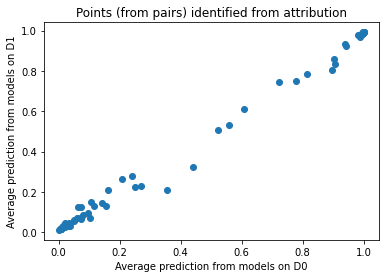

In [732]:
preds = [np.mean(x,0) for x in preds]
plt.scatter(preds[0],preds[1])
plt.title("Points (from pairs) identified from attribution")
plt.xlabel("Average prediction from models on D0")
plt.ylabel("Average prediction from models on D1")

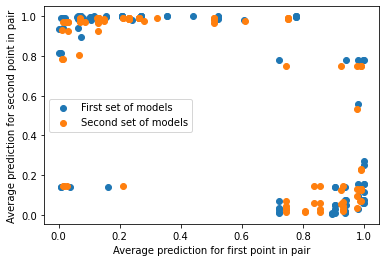

In [733]:
plt.scatter(pred_i[0],pred_j[0], label="First set of models")
plt.scatter(pred_i[1],pred_j[1], label="Second set of models")

plt.xlabel("Average prediction for first point in pair")
plt.ylabel("Average prediction for second point in pair")

plt.legend()

Some peciluar trend here, though- almost all of the pairs have datapoints from both classes, as if the model is trying to make sense of the similarity between property=0 and property=1 labeled data

Total percentage of edges between two colors: 100.00%
Total percentage of edges within first color: 0.00%
Total percentage of edges within second color: 0.00%


Total percentage of edges with one of them as anchor: 25.25%


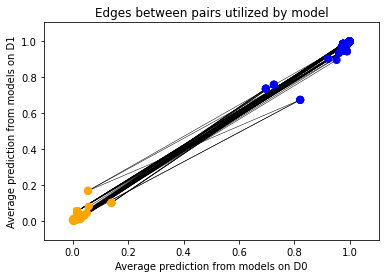

In [697]:
import networkx  as nx
G=nx.Graph()

large_num = int(1e5)
fig, ax = plt.subplots()
node_color_list = []

def add_to_flow(p, q):
    if p < 0.5 and q < 0.5:
        return True
    return False

def lower_left_quad(p, q):
    if add_to_flow(p, q):
        return 'orange'
    return 'blue'

def anchor_point(p, q):
    if np.abs(p - q) < 0.01:
        return True
    return False

def diff_enough(p, q):
    if np.abs(p - q) > 0.03:
        return True
    return False

flow_nodes = []
one_of_them_anchor_nodes = []
for i in range(len(pred_i[0])):
    G.add_node(i,pos=(pred_i[0][i][0],pred_i[1][i][0]))
    node_color_list.append(lower_left_quad(pred_i[0][i][0],pred_i[1][i][0]))
    G.add_node(large_num-i,pos=(pred_j[0][i][0],pred_j[1][i][0]))
    node_color_list.append(lower_left_quad(pred_j[0][i][0],pred_j[1][i][0]))
    # Add orange nodes to one set
    if add_to_flow(pred_i[0][i][0],pred_i[1][i][0]):
        flow_nodes.append(i)
    if add_to_flow(pred_j[0][i][0],pred_j[1][i][0]):
        flow_nodes.append(large_num-i)
    # Also track pairs where one of the points has similar predictions for both sets of models
    # Which might correspond to a rule like 'models that have similar prediction on this, but not on that'
    anchor_1 = anchor_point(pred_i[0][i][0],pred_i[1][i][0])
    anchor_2 = anchor_point(pred_j[0][i][0],pred_j[1][i][0])
    diff_1   = diff_enough(pred_i[0][i][0],pred_i[1][i][0])
    diff_2   = diff_enough(pred_j[0][i][0],pred_j[1][i][0])
#     if np.logical_xor(anchor_1, anchor_2):
    if np.logical_xor(anchor_1, anchor_2) and np.logical_xor(diff_1, diff_2):
        if anchor_1:
            one_of_them_anchor_nodes.append(i)
        else:
            one_of_them_anchor_nodes.append(large_num-i)

for i in range(len(pred_i[0])):
    G.add_edge(i,large_num-i)

pos=nx.get_node_attributes(G,'pos')

nx.draw_networkx(G, pos, ax=ax, with_labels=False, node_size=50, width=0.5, node_color=node_color_list)

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xlabel("Average prediction from models on D0")
plt.ylabel("Average prediction from models on D1")
plt.title("Edges between pairs utilized by model")

num_edges_total = G.number_of_edges()

# Print edge boundary between the two colors
num_edges_cross = len(list(nx.edge_boundary(G, flow_nodes)))
print("Total percentage of edges between two colors: %.2f%%" % (100 * num_edges_cross / num_edges_total))
sum_so_far = num_edges_total - num_edges_cross

# Print edged within first color
num_edges_within_first = len(list(nx.edge_boundary(G, flow_nodes, flow_nodes)))
print("Total percentage of edges within first color: %.2f%%" % (100 * num_edges_within_first / num_edges_total))
sum_so_far -= num_edges_within_first

print("Total percentage of edges within second color: %.2f%%" % (100 * sum_so_far / num_edges_total))
print("\n")

# Also see how many points have one with 'anchor'
num_edges_anchor = len(list(nx.edge_boundary(G, one_of_them_anchor_nodes)))
print("Total percentage of edges with one of them as anchor: %.2f%%" % (100 * num_edges_anchor / num_edges_total))


In [698]:
pred_std_i = [np.std(x,axis=0) for x in pred_i_og]
pred_std_j = [np.std(x,axis=0) for x in pred_j_og]

Models D0: 0.976+/-0.020, 0.006+/-0.004
Models D1: 0.985+/-0.009, 0.004+/-0.002


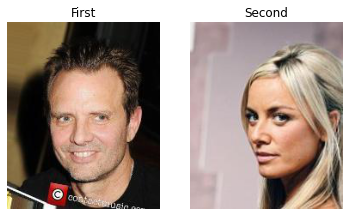

In [699]:
kkk = 0
# Pick images
img_i, img_j = pis[kkk], pjs[kkk]
img_i, img_j = img_i.cpu().numpy(), img_j.cpu().numpy()
img_i = np.transpose(img_i, (1, 2, 0))
img_j = np.transpose(img_j, (1, 2, 0))
# Convert data back to [-1, 1]
img_i = (img_i/2 + 0.5)
img_j = (img_j/2 + 0.5)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(img_i)
plt.axis('off')
ax.set_title('First')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(img_j)
plt.axis('off')
ax.set_title('Second')

# Print out predictions from first dist of models, v/s second dist of models
print("Models D0: %.3f+/-%.3f, %.3f+/-%.3f" % (pred_i[0][kkk][0], pred_std_i[0][kkk][0], pred_j[0][kkk][0], pred_std_j[0][kkk][0]))
print("Models D1: %.3f+/-%.3f, %.3f+/-%.3f" % (pred_i[1][kkk][0], pred_std_i[1][kkk][0], pred_j[1][kkk][0], pred_std_j[1][kkk][0]))

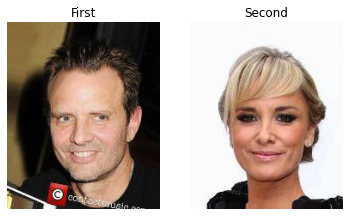

In [700]:
most_common_imgs = attacker_obj.seed_data_ds[[most_common_first, most_common_second]].cuda()

imgs_plot = most_common_imgs.cpu().numpy()
imgs_plot = np.transpose(imgs_plot, (0, 2, 3, 1))
# Convert data back to [-1, 1]
imgs_plot = (imgs_plot/2 + 0.5)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(imgs_plot[0])
plt.axis('off')
ax.set_title('First')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(imgs_plot[1])
plt.axis('off')
ax.set_title('Second')


acts_common_1 = np.array([m.cuda().eval()(most_common_imgs, get_all=True, detach_before_return=True)[focus_layer].cpu().numpy() for m in models_vic_1])
acts_common_2 = np.array([m.cuda().eval()(most_common_imgs, get_all=True, detach_before_return=True)[focus_layer].cpu().numpy() for m in models_vic_1])


In [701]:
preds_common_1 = sigmoid(np.array([m.cuda().eval()(most_common_imgs).cpu().detach().numpy() for m in models_vic_1]))
preds_common_2 = sigmoid(np.array([m.cuda().eval()(most_common_imgs).cpu().detach().numpy() for m in models_vic_2]))
preds_common_1 = preds_common_1[:,:,0]
preds_common_2 = preds_common_2[:,:,0]

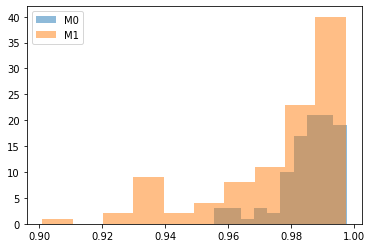

In [702]:
plt.hist(preds_common_2[:, 0], alpha=0.5, label='M0')
plt.hist(preds_common_1[:, 0], alpha=0.5, label='M1')
plt.legend()

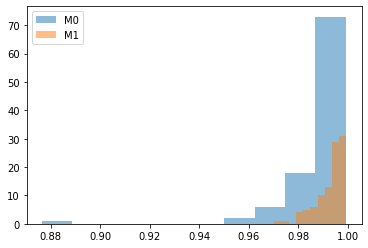

In [703]:
plt.hist(preds_common_2[:, 1], alpha=0.5, label='M0')
plt.hist(preds_common_1[:, 1], alpha=0.5, label='M1')
plt.legend()

In [704]:
from sklearn import tree

# See distinguishing accuracy of a simple linear model using these two features
X_feat = np.concatenate((preds_common_1, preds_common_2), 0)
labels = np.concatenate((np.zeros(preds_common_1.shape[0]), np.ones(preds_common_1.shape[0])))
reg = tree.DecisionTreeClassifier(max_depth=2).fit(X_feat, labels)
print("Distinguishing acc using just these two prediction scores: %.3f" % reg.score(X_feat, labels))

Distinguishing acc using just these two prediction scores: 0.610


In [360]:
# Now, look at t_SNE embeddings for shortlisted images
focus_layer = important_layers[0]

pis_relevant_1 = np.array([m.cuda().eval()(pis, get_all=True, detach_before_return=True)[focus_layer].cpu().numpy() for m in models_vic_1])
pis_relevant_2 = np.array([m.cuda().eval()(pis, get_all=True, detach_before_return=True)[focus_layer].cpu().numpy() for m in models_vic_2])
pjs_relevant_1 = np.array([m.cuda().eval()(pjs, get_all=True, detach_before_return=True)[focus_layer].cpu().numpy() for m in models_vic_1])
pjs_relevant_2 = np.array([m.cuda().eval()(pjs, get_all=True, detach_before_return=True)[focus_layer].cpu().numpy() for m in models_vic_2])
# Shape: (models, pairs, per-pair features)

pis_relevant_1 = pis_relevant_1.reshape(-1, pis_relevant_1.shape[2])
pis_relevant_2 = pis_relevant_2.reshape(-1, pis_relevant_2.shape[2])
pjs_relevant_1 = pjs_relevant_1.reshape(-1, pjs_relevant_1.shape[2])
pjs_relevant_2 = pjs_relevant_2.reshape(-1, pjs_relevant_2.shape[2])

IndexError: index 20 is out of bounds for axis 0 with size 9

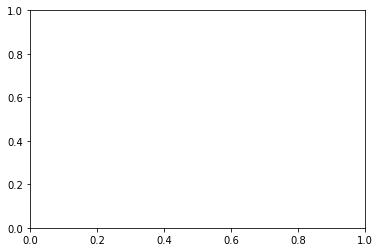

In [153]:
n=20
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(pred_i[0][n],pred_j[0][n])
plt.scatter(pred_i[1][n],pred_j[1][n])